## Simple computational model to validate activity flow mapping method

Outline of procedures:
- Create a simple rate code neural network model (just simple interactions for now)
- Specify a structural connectivity matrix for network with 3 modules (network communities)
- Specify random synaptic weights on the connectivity network
- Simulate resting-state activity as pink noise random activity in model 
- Simulate fMRI data collection: Convolve with HRF, then downsample
- Simulate evoked activity in model
- Test if activity flow mapping works with simulated fMRI data, using rest FC and task FC



In [1]:
#Basic variables

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

numRegions=300

In [2]:
#Creating network model with random connectivity, 15% density with random synaptic strengths
structConnVector=np.random.uniform(0,1,(numRegions,numRegions))>.85
#Add self-connections (important if adding autocorrelation later)
np.fill_diagonal(structConnVector,10)
#Create modular structural network (3 modules)
numModules=3
numRPerModule=int(round(numRegions/numModules))
lastModuleNode=-1
for moduleNum in range(0,numModules):
    for thisNodeNum in range(lastModuleNode+1,lastModuleNode+numRPerModule-1):
        #structConnVector[thisNodeNum,thisNodeNum-1]=(structConnVector[thisNodeNum,thisNodeNum-1]+1)>0
        #structConnVector[thisNodeNum-1,thisNodeNum]=structConnVector[thisNodeNum,thisNodeNum-1]      
        #Set this node to connect to 10 random other nodes in module
        for i in range(1,numRPerModule/2):
            randNodeInModule=int(np.random.uniform(lastModuleNode+1,lastModuleNode+numRPerModule-1,(1,1)))
            structConnVector[thisNodeNum,randNodeInModule]=1
    lastModuleNode=lastModuleNode+numRPerModule

#Adding synaptic weights to existing structural connections (small random synapse strength variation)
synapticWeightVector=structConnVector*(1+np.random.standard_normal((numRegions,numRegions))*.001)

#Adding synaptic mini-communities (within community 1)
synapticWeightVector[0:50,50:100]=synapticWeightVector[0:50,50:100]*0.5
synapticWeightVector[50:100,0:50]=synapticWeightVector[50:100,0:50]*0.5
synapticWeightVector[0:50,0:50]=synapticWeightVector[0:50,0:50]*1.5
synapticWeightVector[50:100,50:100]=synapticWeightVector[50:100,50:100]*1.5

#Implement global coupling parameter
G=1
synapticWeightVector=G*synapticWeightVector

#Implement local independence parameter
Indep=1

(300, 300)


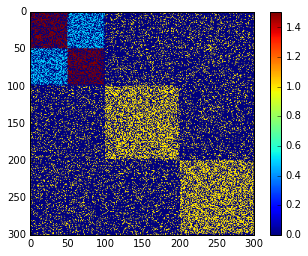

In [3]:
#Visualize basic network structure
print(np.shape(synapticWeightVector))
plt.imshow(synapticWeightVector)
plt.colorbar()
plt.savefig('ActflowSim_StructMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

### Editing random activity in model to implement Firing Rate Model (Ermentrout, 2003)

#### Mathematical formalization of model

$$\tau_i \frac{dx_i}{dt} = -x_i + f_i\Big( \sum_{j=1}^n w_{ji} x_j + bias_i \Big) \quad i=[1..n] \qquad \qquad (1)$$

where $w_{ji}$ refers to the synaptic weight vector from neuron $i$ to $j$, $x_{j}$ refers to the spontaneous activity at region $j$. $bias_i$ is the bias of neuron $i$, but for this model is set to 0. $\tau_i$ is the time constant for region $i$, and is set to 1ms for all regions currently. 

Initial condition is set to 0 for all regions at timepoint 0.

Define the sigmoid f(x):
$$f(x) = \frac{1}{1-e^{-x}}$$

In [4]:
#Simulate random activity in model (sum of activity weighted by synapses)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# Specify simulation length parameters
numTimePoints=20000



def networkModel1(G=1.0, Indep=1.0, stimTimes=[], stimRegions=None, synapticWeightVector=synapticWeightVector, numTimePoints=numTimePoints):
    """
    Network model simulation, v1
    Independent activity variable is modulated within the sigmoid function, via self-connection weights
    Global coupling paramter is modulated via inter-regional synaptic weight matrix
    """
    ## Static model parameters
    # Time step for Runge-Kutta method
    dt = 1
    # Without loss of generality, select time constant to be 10 for all ROIs
    tau = np.zeros(shape=(numRegions,))
    tau[:] = 1
    # Select bias parameter for all ROIs
    bias = np.zeros(shape=(numRegions,))
    ##
    
    G = np.float64(G)
    Indep = np.float64(Indep)
    ## Begin simulation set-up
    # Empty matrix for simulated timeseries
    simulatedTimeseries=np.zeros((numTimePoints,numRegions))
    #Each state modifies previous state (creating some autocorrelation; pink noise)
    autocorrFactor=0.10

    # Modulate synaptic weight matrix by coupling parameter, G
    GlobalCouplingMat = synapticWeightVector*G
    np.fill_diagonal(GlobalCouplingMat,0)
    # Modulate self connection 'independence' parameter, Indep
    IndepVarMat = np.identity(numRegions)*Indep
    IndepVarMat = np.multiply(IndepVarMat,synapticWeightVector)
    
    # Now reconstruct synapticWeightMatrix
    synapticWeightVector = GlobalCouplingMat + IndepVarMat
    
    # Begin computing simulation
    for thisTimePoint in range(0,numTimePoints):
        # Generate spontaneous activity for initial state
        spontActVector=np.random.normal(0,1,(numRegions,))
        stimActVector=np.zeros(numRegions)

        # Specify spontaneous input activity at this time point and task activity
        if thisTimePoint in stimTimes:
            #Include moment-to-moment variability in task stimulation
            stimAct=np.ones(len(stimRegions))*np.random.normal(1,0.5,)
            #stimAct=np.ones(len(stimRegions))*0.5   #excluding moment-to-moment variability in task stimulation
            stimActVector[stimRegions]=stimActVector[stimRegions]+stimAct
        # Add spontaneous activity vector with task stimulus
        spontActVector=(autocorrFactor*spontActVector)+np.random.normal(0,1,(numRegions,))+stimActVector
        spontActVectorToMat=np.kron(np.ones((numRegions,1)),spontActVector)
        
        if thisTimePoint==0: # set initial condition
            simulatedTimeseries[thisTimePoint,] = 0.0 # 0 for all regions
        else:
            ## Solve using Runge-Kutta Order 2 Method          

            # Compute slope for k1
            weightedSpontActivity = np.sum(np.multiply(spontActVectorToMat,synapticWeightVector), axis=1)
            sigmoid_outk1 = sigmoid(bias + weightedSpontActivity)
            k1 = (-simulatedTimeseries[-1,] + sigmoid_outk1)/tau
            # Specify midpoint based on Runge-Kutta order 2 method
            x_mid = simulatedTimeseries[-1,] + k1*dt
            x_mid_synapticInputVector=np.kron(np.ones((numRegions,1)),x_mid)
            # Compute slope for k2
            sigmoid_outk2 = sigmoid(bias + weightedSpontActivity) 
            k2 = (-x_mid + sigmoid_outk2)/tau

            # Result
            x_tmp = simulatedTimeseries[-1,] + (dt*(.5*k1 + .5*k2))
            simulatedTimeseries[thisTimePoint,] = x_tmp

    return simulatedTimeseries

G=np.float64(G)
Indep=np.float64(Indep)
simulatedRestTimeseries = networkModel1(G=G, Indep=Indep, stimTimes=[], stimRegions=None, numTimePoints=numTimePoints)


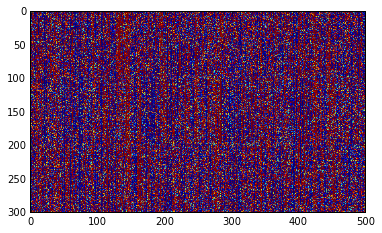

In [5]:
#Visualize simulated time series
plt.imshow(np.transpose(simulatedRestTimeseries[1500:2000,:]))

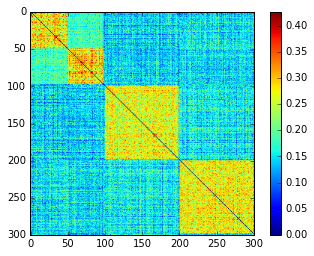

In [6]:
#Produce rest FC matrix based on produced spontaneous time series
fcMat_restPreFMRI=np.corrcoef(simulatedRestTimeseries,rowvar=0)
np.fill_diagonal(fcMat_restPreFMRI,0)
plt.imshow(fcMat_restPreFMRI)
plt.colorbar()

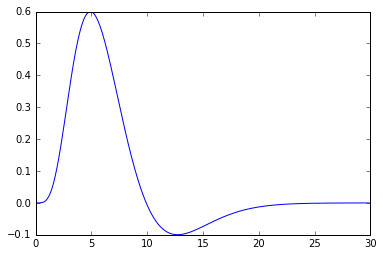

In [7]:
#Simulate fMRI data collection
#Based on http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html

#Creating a hemodynamic response function

from scipy.stats import gamma

def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

#x = np.arange(0, 25, 0.01)
#plt.plot(x, hrf(x))

simsample_rate=0.1 #Every 100ms
simsample_times = np.arange(0, 30, simsample_rate)
hrf_at_simsample = hrf(simsample_times)
plt.plot(simsample_times, hrf_at_simsample)


(1000, 300)


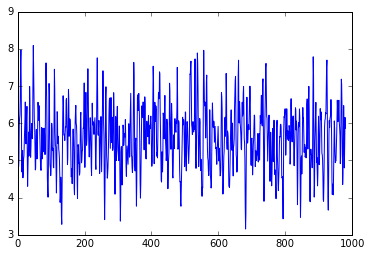

In [8]:
#Convolve simulated time series with HRF

simulatedTimeseries_convolved=np.ones(np.shape(simulatedRestTimeseries))
for regionNum in range(0,numRegions):
    convolved = np.convolve(simulatedRestTimeseries[:,regionNum], hrf_at_simsample)
    n_to_remove = len(hrf_at_simsample) - 1
    convolved = convolved[:-n_to_remove]
    simulatedTimeseries_convolved[:,regionNum]=convolved

#print(np.shape(simulatedTimeseries_convolved))
#plt.plot(simulatedTimeseries_convolved[:,1])

#Downsample fMRI time series
TR=2
dt_rec=0.1
n_skip_BOLD = int(TR/dt_rec)
BOLD_rec = simulatedTimeseries_convolved[::n_skip_BOLD]

print(np.shape(BOLD_rec))
plt.plot(BOLD_rec[20:,1])


(1000, 300)


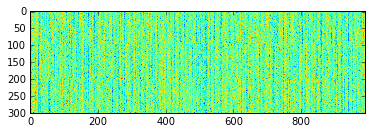

In [9]:
#Visualize simulated fMRI time series
print(np.shape(BOLD_rec))
plt.imshow(np.transpose(BOLD_rec[10:,]))
#plt.colorbar()

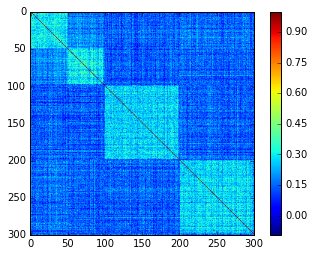

In [10]:
#Produce rest FC matrix based on produced spontaneous fMRI time series
fcMat_rest=np.corrcoef(BOLD_rec[10:,],rowvar=0)
#np.fill_diagonal(fcMat_rest,0)
plt.imshow(fcMat_rest)
plt.colorbar()
plt.savefig('ActflowSim_RestfMRI_FCMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

In [11]:
# #Estimate rest FC matrix using multiple linear regression of fMRI time series
# import statsmodels.api as sm
# restfMRIData=BOLD_rec[10:,]
# numTimepoints=np.shape(restfMRIData)[0]
# restFC_betas=np.ones([numRegions,numRegions])
# for regionNum in range(0,numRegions):
#     otherRegions=range(numRegions)
#     otherRegions.remove(regionNum)
#     X=restfMRIData[:,otherRegions]
#     X = sm.add_constant(X)
#     y=restfMRIData[:,regionNum]
#     model = sm.OLS(y, X)
#     results = model.fit()
#     #print(results.summary())
#     #Save betas
#     restFC_betas[regionNum,otherRegions]=results.params[1:numRegions+1]
#     #Save residuals
#     #TaskStim_TaskTimeRegressed[:,regionNum]=results.resid

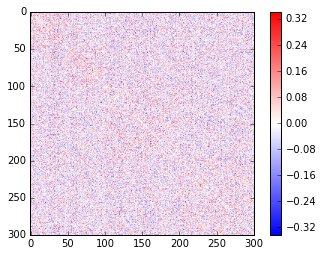

In [12]:
# #Visualize multiple regression-based resting-state FC matrix
# np.fill_diagonal(restFC_betas,0)
# plt.imshow(restFC_betas, cmap="bwr")
# plt.colorbar()
# plt.savefig('ActflowSim_RestfMRI_MultRegFC_FCMat.pdf',dpi=600,transparent=True, bbox_inches='tight')

##Task-evoked activity simulation

In [13]:
#Simulate random activity in model, WITH TASK-EVOKED STIMULATION (sum of activity weighted by synapses)
numTasks=6
stimTimes=np.concatenate((range(5000,7000),range(10000,12000),range(15000,17000)),axis=0)
numTimePoints=20000
stimRegionsByTask=np.array((range(5,10),range(90,95),range(105,110),range(190,195),range(205,210),range(290,295)))
simulatedTimeseriesTaskStim=np.zeros((numTimePoints,numRegions,numTasks))
for taskNum in range(numTasks):
    stimRegions=stimRegionsByTask[taskNum]
    simulatedTimeseriesTaskStim[:,:,taskNum] = networkModel1(G=G, Indep=Indep, stimTimes=stimTimes, stimRegions=stimRegions, numTimePoints=numTimePoints)


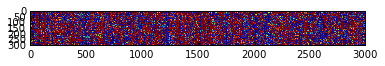

In [14]:
#Visualize simulated time series
plt.imshow(np.transpose(simulatedTimeseriesTaskStim[9500:12500,:,0]))

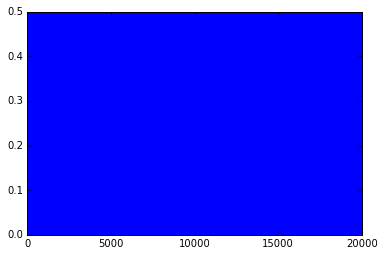

In [15]:
#Plot example (stimulated) time series
plt.plot(simulatedTimeseriesTaskStim[:,5,0])

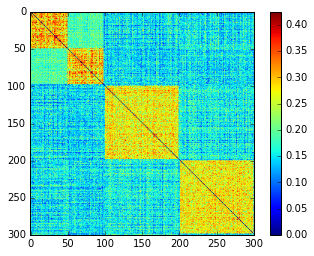

In [16]:
#Produce task FC matrix based on produced time series
fcMat_taskActFC=np.corrcoef(simulatedTimeseriesTaskStim[:,:,0],rowvar=0)
np.fill_diagonal(fcMat_taskActFC,0)
plt.imshow(fcMat_taskActFC)
plt.colorbar()

In [17]:
#Implement activity flow mapping PRIOR TO FMRI SIMULATION, predicting held-out region's activityfor heldOutRegion in range(numRegions):

#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1
import statsmodels.api as sm
X=taskStimTimeseries
#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
numTimepoints=np.shape(taskStimTimeseries)[0]
TaskStim_TaskTimeRegressed=np.ones([numTimepoints,numRegions])
TaskStim_GLMBetas=np.ones([numRegions,1])
for regionNum in range(0,numRegions):
    y=simulatedTimeseriesTaskStim[:,regionNum,0]
    model = sm.OLS(y, X)
    results = model.fit()
    #print(results.summary())
    #Save betas
    TaskStim_GLMBetas[regionNum]=results.params[1]
    #Save residuals
    TaskStim_TaskTimeRegressed[:,regionNum]=results.resid

#Actflow mapping
evokedTaskActivations=np.transpose(TaskStim_GLMBetas)
fcMat_taskActFC_postRegress=np.corrcoef(TaskStim_TaskTimeRegressed,rowvar=0)
actPredVector_restFC=np.zeros((numRegions,))
actPredVector_taskFC=np.zeros((numRegions,))
actPredVector_taskFCPostRegress=np.zeros((numRegions,))
for heldOutRegion in range(numRegions):
    regionList=range(numRegions)
    regionList.remove(heldOutRegion)
    evokedActVectorToMat=np.kron(np.ones((numRegions,1)),evokedTaskActivations)

    actPredVector_restFC[heldOutRegion]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_restPreFMRI[heldOutRegion,regionList], axis=0))
    actPredVector_taskFC[heldOutRegion]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_taskActFC[heldOutRegion,regionList], axis=0))
    actPredVector_taskFCPostRegress[heldOutRegion]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_taskActFC_postRegress[heldOutRegion,regionList], axis=0))
    
#Test for accuracy of actflow prediction
predAcc_restFC_PreFMRI=np.corrcoef(evokedTaskActivations,actPredVector_restFC)
predAcc_taskFC_PreFMRI=np.corrcoef(evokedTaskActivations,actPredVector_taskFC)
predAcc_taskFC_PreFMRI_PostRegress=np.corrcoef(evokedTaskActivations,actPredVector_taskFCPostRegress)
print("==Activity flow mapping results, PRE-FMRI==")
print("Correlation between predicted and actual activation patterns (restFC only):")
print(predAcc_restFC_PreFMRI)
print("Correlation between predicted and actual activation patterns (taskFC only):")
print(predAcc_taskFC_PreFMRI)
print("Correlation between predicted and actual activation patterns (taskFC only; POST-REGRESSION):")
print(predAcc_taskFC_PreFMRI_PostRegress)

==Activity flow mapping results, PRE-FMRI==
Correlation between predicted and actual activation patterns (restFC only):
[[ 1.          0.62795737]
 [ 0.62795737  1.        ]]
Correlation between predicted and actual activation patterns (taskFC only):
[[ 1.         0.7943661]
 [ 0.7943661  1.       ]]
Correlation between predicted and actual activation patterns (taskFC only; POST-REGRESSION):
[[ 1.          0.67299192]
 [ 0.67299192  1.        ]]


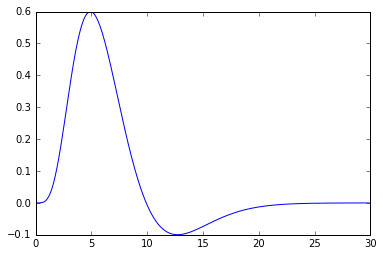

In [18]:
#Simulate fMRI data collection
#Based on http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html

#Creating a hemodynamic response function

from scipy.stats import gamma

def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

#x = np.arange(0, 25, 0.01)
#plt.plot(x, hrf(x))

simsample_rate=0.1 #Every 100ms
simsample_times = np.arange(0, 30, simsample_rate)
hrf_at_simsample = hrf(simsample_times)
plt.plot(simsample_times, hrf_at_simsample)


(20000, 300, 6)


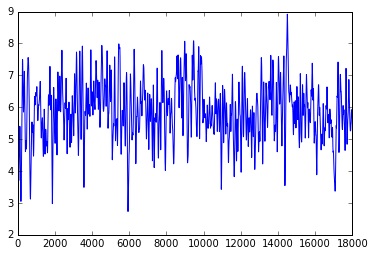

In [19]:
#Convolve simulated time series with HRF

simulatedTimeseriesTaskStim_convolved=np.ones(np.shape(simulatedTimeseriesTaskStim))
for taskNum in range(numTasks):
    for regionNum in range(0,numRegions):
        convolved = np.convolve(simulatedTimeseriesTaskStim[:,regionNum,taskNum], hrf_at_simsample)
        n_to_remove = len(hrf_at_simsample) - 1
        convolved = convolved[:-n_to_remove]
        simulatedTimeseriesTaskStim_convolved[:,regionNum,taskNum]=convolved

print(np.shape(simulatedTimeseriesTaskStim_convolved))
plt.plot(simulatedTimeseriesTaskStim_convolved[2000:,1,0])


(1000, 300, 6)


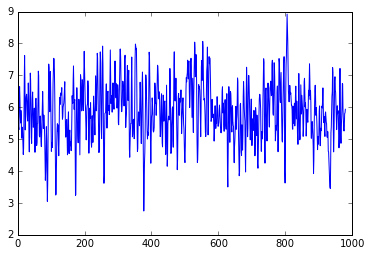

In [20]:
#Downsample fMRI time series, add noise
TR=2
dt_rec=0.1
n_skip_BOLD = int(TR/dt_rec)
BOLD_rec_TaskStim = simulatedTimeseriesTaskStim_convolved[::n_skip_BOLD]
BOLD_rec_TaskStim=BOLD_rec_TaskStim+np.random.normal(0,.01,np.shape(BOLD_rec_TaskStim))

print(np.shape(BOLD_rec_TaskStim))
plt.plot(BOLD_rec_TaskStim[20:,1,0])
plt.savefig('ActflowSim_TaskfMRI_TaskActivityExample.pdf',dpi=600,transparent=True, bbox_inches='tight')

(1000, 300, 6)


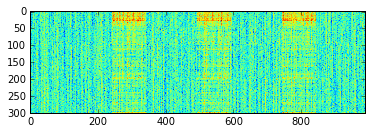

In [21]:
#Visualize simulated fMRI time series
print(np.shape(BOLD_rec_TaskStim))
plt.imshow(np.transpose(BOLD_rec_TaskStim[10:,:,0]))
plt.savefig('ActflowSim_TaskfMRI_TaskActivityAllRegions.pdf',dpi=600,transparent=True, bbox_inches='tight')

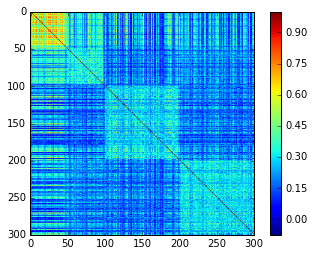

In [22]:
#Produce task FC matrix based on produced fMRI time series
fcMat_TaskStim=np.corrcoef(BOLD_rec_TaskStim[10:,:,0],rowvar=0)
plt.imshow(fcMat_TaskStim)
plt.colorbar()

#Run for all tasks
fcMat_TaskStimByTask=np.zeros((np.shape(fcMat_TaskStim)[0],np.shape(fcMat_TaskStim)[1],numTasks))
for taskNum in range(numTasks):
    fcMat_TaskStimByTask[:,:,taskNum]=np.corrcoef(BOLD_rec_TaskStim[10:,:,taskNum],rowvar=0)

(1000,)


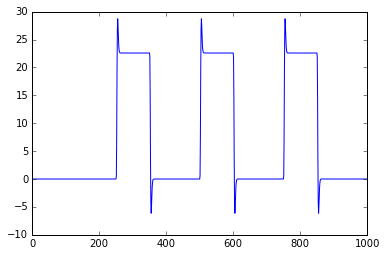

In [23]:
#Run GLM; get betas and "regress out" stimulation timing
taskStimTimeseries=np.ones(np.shape(simulatedTimeseriesTaskStim)[0])*0
taskStimTimeseries[stimTimes]=taskStimTimeseries[stimTimes]+1

convolved = np.convolve(taskStimTimeseries, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = convolved[:-n_to_remove]
taskStimTimeseries_convolved=convolved

#Downsample fMRI time series
TR=2
dt_rec=0.1
n_skip_BOLD = int(TR/dt_rec)
taskStimTimeseries_rec = taskStimTimeseries_convolved[::n_skip_BOLD]

print(np.shape(taskStimTimeseries_rec))
plt.plot(taskStimTimeseries_rec)

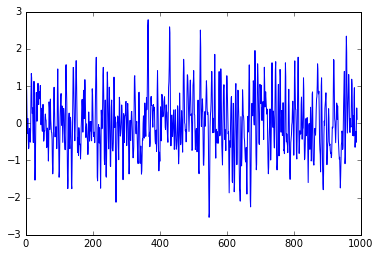

In [24]:
import statsmodels.api as sm

X=taskStimTimeseries_rec[10:,]
#Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)

numTimepoints=np.shape(BOLD_rec_TaskStim)[0]-10
BOLD_rec_TaskStim_TaskTimeRegressed=np.ones([numTimepoints,numRegions,numTasks])
BOLD_rec_TaskStim_GLMBetas=np.ones([numRegions,numTasks])

for taskNum in range(numTasks):
    for regionNum in range(0,numRegions):
        y=BOLD_rec_TaskStim[10:,regionNum,taskNum]

        model = sm.OLS(y, X)

        results = model.fit()
        #print(results.summary())
        #Save betas
        BOLD_rec_TaskStim_GLMBetas[regionNum,taskNum]=results.params[1]
        #Save residuals
        BOLD_rec_TaskStim_TaskTimeRegressed[:,regionNum,taskNum]=results.resid

plt.plot(BOLD_rec_TaskStim_TaskTimeRegressed[:,0,0])


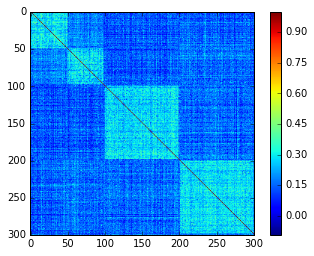

In [25]:
#Produce task FC matrix based on produced fMRI time series, AFTER REGRESSING out task timing
fcMat_TaskStim_TaskTimeRegressed=np.corrcoef(BOLD_rec_TaskStim_TaskTimeRegressed[10:,:,0],rowvar=0)
plt.imshow(fcMat_TaskStim_TaskTimeRegressed)
plt.colorbar()

#Run for all tasks
fcMat_TaskStim_TaskTimeRegressedByTask=np.zeros((np.shape(fcMat_TaskStim_TaskTimeRegressed)[0],np.shape(fcMat_TaskStim_TaskTimeRegressed)[1],numTasks))
for taskNum in range(numTasks):
    fcMat_TaskStim_TaskTimeRegressedByTask[:,:,taskNum]=np.corrcoef(BOLD_rec_TaskStim_TaskTimeRegressed[10:,:,taskNum],rowvar=0)

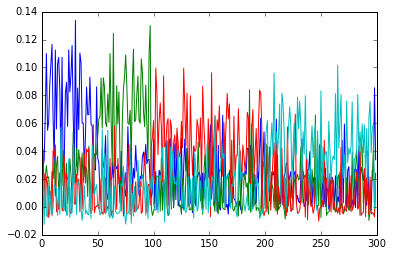

In [26]:
#Plot activation vectors
plt.plot(BOLD_rec_TaskStim_GLMBetas[:,0])
plt.plot(BOLD_rec_TaskStim_GLMBetas[:,1])
plt.plot(BOLD_rec_TaskStim_GLMBetas[:,2])
plt.plot(BOLD_rec_TaskStim_GLMBetas[:,4])
#plt.imshow(np.transpose(BOLD_rec_TaskStim_GLMBetas)
#plt.savefig('ActflowSim_TaskfMRI_TaskActivityAllRegions.pdf',dpi=600,transparent=True, bbox_inches='tight')

In [27]:
#Actflow mapping
import scipy
#Run for each task
predAcc_restFC_PreFMRIByTask=np.zeros((numTasks,1))
predAcc_taskFC_PreFMRIByTask=np.zeros((numTasks,1))
predAcc_taskFC_PreFMRI_PostRegressByTask=np.zeros((numTasks,1))
predAcc_restFC_MultRegFC_PostFMRIByTask=np.zeros((numTasks,1))

actPredVector_restFC=np.zeros((numRegions,numTasks))
actPredVector_taskFC=np.zeros((numRegions,numTasks))
actPredVector_taskFCPostRegress=np.zeros((numRegions,numTasks))
actPredVector_restFC_MultRegFC=np.zeros((numRegions,numTasks))


for taskNum in range(numTasks):

    evokedTaskActivations=np.transpose(BOLD_rec_TaskStim_GLMBetas[:,taskNum])
    for heldOutRegion in range(numRegions):
        regionList=range(numRegions)
        regionList.remove(heldOutRegion)
        evokedActVectorToMat=np.kron(np.ones((numRegions,1)),evokedTaskActivations)

        actPredVector_restFC[heldOutRegion,taskNum]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_rest[heldOutRegion,regionList], axis=0))
        actPredVector_taskFC[heldOutRegion,taskNum]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_TaskStimByTask[heldOutRegion,regionList,taskNum], axis=0))
        actPredVector_taskFCPostRegress[heldOutRegion,taskNum]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*fcMat_TaskStim_TaskTimeRegressedByTask[heldOutRegion,regionList,taskNum], axis=0))
        actPredVector_restFC_MultRegFC[heldOutRegion,taskNum]=np.mean(np.mean(evokedActVectorToMat[heldOutRegion,regionList]*restFC_betas[heldOutRegion,regionList], axis=0))
        
    #Test for accuracy of actflow prediction
    predAcc_restFC_PreFMRIByTask[taskNum]=np.corrcoef(evokedTaskActivations,actPredVector_restFC[:,taskNum])[0,1]
    predAcc_taskFC_PreFMRIByTask[taskNum]=np.corrcoef(evokedTaskActivations,actPredVector_taskFC[:,taskNum])[0,1]
    predAcc_taskFC_PreFMRI_PostRegressByTask[taskNum]=np.corrcoef(evokedTaskActivations,actPredVector_taskFCPostRegress[:,taskNum])[0,1]
    predAcc_restFC_MultRegFC_PostFMRIByTask[taskNum]=np.corrcoef(evokedTaskActivations,actPredVector_restFC_MultRegFC[:,taskNum])[0,1]
    print("==Activity flow mapping results, with fMRI, task ", taskNum, "==")
    print("Correlation between predicted and actual activation patterns (restFC only):")
    print(predAcc_restFC_PreFMRIByTask[taskNum])
    print("Correlation between predicted and actual activation patterns (taskFC only):")
    print(predAcc_taskFC_PreFMRIByTask[taskNum])
    print("Correlation between predicted and actual activation patterns (taskFC only; POST-REGRESSION):")
    print(predAcc_taskFC_PreFMRI_PostRegressByTask[taskNum])
    print("Correlation between predicted and actual activation patterns (restFC only):")
    print(predAcc_restFC_MultRegFC_PostFMRIByTask[taskNum])


('==Activity flow mapping results, with fMRI, task ', 0, '==')
Correlation between predicted and actual activation patterns (restFC only):
[ 0.4426066]
Correlation between predicted and actual activation patterns (taskFC only):
[ 0.94413398]
Correlation between predicted and actual activation patterns (taskFC only; POST-REGRESSION):
[ 0.52692834]
Correlation between predicted and actual activation patterns (restFC only):
[ 0.7585074]
('==Activity flow mapping results, with fMRI, task ', 1, '==')
Correlation between predicted and actual activation patterns (restFC only):
[ 0.57090716]
Correlation between predicted and actual activation patterns (taskFC only):
[ 0.9478209]
Correlation between predicted and actual activation patterns (taskFC only; POST-REGRESSION):
[ 0.53985106]
Correlation between predicted and actual activation patterns (restFC only):
[ 0.74804194]
('==Activity flow mapping results, with fMRI, task ', 2, '==')
Correlation between predicted and actual activation patterns

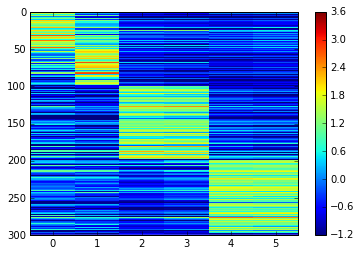

In [28]:
#Plot predicted GLM beta values, rest FC
#print(np.shape(actPredVector_restFC))
#plt.plot(actPredVector_restFC)
#Z-normalize
taskMeans=np.kron(np.ones((numRegions,1)),np.mean(actPredVector_restFC,axis=0))
taskStdevs=np.kron(np.ones((numRegions,1)),np.std(actPredVector_restFC,axis=0))
actPredVector_restFC_normed=(actPredVector_restFC-taskMeans)/taskStdevs
plt.imshow(actPredVector_restFC_normed, aspect='auto', interpolation='none', vmin=-1.2, vmax=3.6)
plt.colorbar()
plt.savefig('ActflowSim_RestfMRI_PredictedActivations.pdf',dpi=600,transparent=True, bbox_inches='tight')

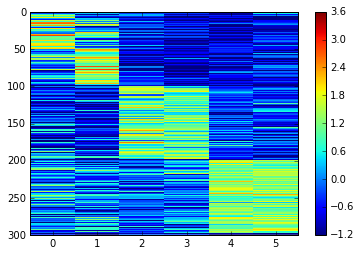

In [29]:
#Plot predicted GLM beta values, task-regressed FC
#Z-normalize
taskMeans=np.kron(np.ones((numRegions,1)),np.mean(actPredVector_taskFCPostRegress,axis=0))
taskStdevs=np.kron(np.ones((numRegions,1)),np.std(actPredVector_taskFCPostRegress,axis=0))
actPredVector_taskFCPostRegress_normed=(actPredVector_taskFCPostRegress-taskMeans)/taskStdevs
plt.imshow(actPredVector_taskFCPostRegress_normed, aspect='auto', interpolation='none', vmin=-1.2, vmax=3.6)
plt.colorbar()

(300, 6)


(array([ 4.43974562,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  4.43974562,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  4.43974562,  0.        ,
         0.        ,  0.        ,  0.        ,  4.43974562,  4.43974562,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  4.43974562]),
 array([-1.28137896, -1.24383927, -1.20629958, -1.16875989, -1.13122021,
        -1.09368052, -1.05614083, -1.01860114, -0.98106145, -0.94352176,
        -0.90598208, -0.86844239, -0.8309027 , -0.79336301, -0.75582332,
        -0.71828363, -0.68074395, -0.64320426, -0

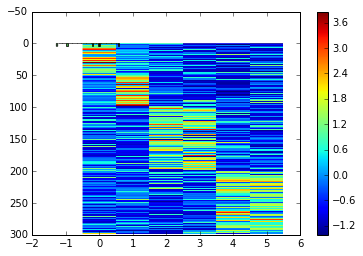

In [30]:
#Plot actual GLM beta values
print(np.shape(actPredVector_taskFC))
#plt.imshow(BOLD_rec_TaskStim_GLMBetas, aspect='auto', interpolation='none')
#plt.colorbar()
#Z-normalize
taskMeans=np.kron(np.ones((numRegions,1)),np.mean(BOLD_rec_TaskStim_GLMBetas,axis=0))
taskStdevs=np.kron(np.ones((numRegions,1)),np.std(BOLD_rec_TaskStim_GLMBetas,axis=0))
BOLD_rec_TaskStim_GLMBetas_normed=(BOLD_rec_TaskStim_GLMBetas-taskMeans)/taskStdevs
plt.imshow(BOLD_rec_TaskStim_GLMBetas_normed, aspect='auto', interpolation='none')
plt.colorbar()
plt.savefig('ActflowSim_ActualActivations.pdf',dpi=600,transparent=True, bbox_inches='tight')
plt.hist(BOLD_rec_TaskStim_GLMBetas_normed[1,:], 50, normed=1, facecolor='green', alpha=0.75)

In [31]:
print(np.mean(predAcc_restFC_PreFMRIByTask))

0.528478073265


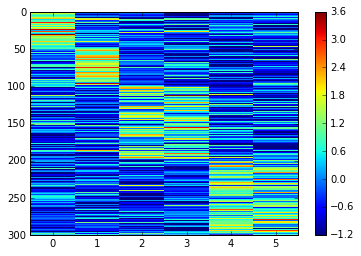

In [32]:
#Plot predicted GLM beta values, rest FC
#print(np.shape(actPredVector_restFC))
#plt.plot(actPredVector_restFC)
#Z-normalize
taskMeans=np.kron(np.ones((numRegions,1)),np.mean(actPredVector_restFC_MultRegFC,axis=0))
taskStdevs=np.kron(np.ones((numRegions,1)),np.std(actPredVector_restFC_MultRegFC,axis=0))
actPredVector_restFC_MultFC_normed=(actPredVector_restFC_MultRegFC-taskMeans)/taskStdevs
plt.imshow(actPredVector_restFC_MultFC_normed, aspect='auto', interpolation='none', vmin=-1.2, vmax=3.6)
plt.colorbar()
plt.savefig('ActflowSim_RestfMRI_MultRegFC_PredictedActivations.pdf',dpi=600,transparent=True, bbox_inches='tight')

In [33]:
print(np.mean(predAcc_restFC_MultRegFC_PostFMRIByTask))

0.698664708697


# 